# 1. Beyond-Sound_AI-Powered-Visual-Speech-Recognition

## 1.1. Install and Import Dependencies

We will be requiring a bunch of different python libraries for video processing and model creation purposes. Its better to check beforehand if all the libraries are properly installed and imported to avoid unnecessary errors.

In [1]:
!mkdir models

In [2]:
'''
  Check if the libraries are installed properly

'''

!pip install torch   # Allow us to build our neural network. Chosen PyTorch for this task.
!pip install torchvision   # Torchvision library provides extra features and functions to process visual information
!pip install opencv-python   # Library for Image and Video transformations
!pip install matplotlib   # Helps visualize how our preprocessed videos and frames looks like
!pip install imageio   # Creates gif from image frames, thus letting us know what's happening in multiple frames stacked together
!pip install gdown   # Allow us to download dataset from google drive. Can also use kagglehub for datasets in kaggle

In [3]:
'''
  Import the required dependencies.

'''

import os
import cv2
import torch
import numpy as np
from typing import List, Tuple
from matplotlib import pyplot as plt
import imageio
from torchvision import transforms
import gdown

In [4]:
'''
  Check if the libraries are properly imported.

'''


print("OpenCV version: ", cv2.__version__)
print("NumPy version: ", np.__version__)
print("ImageIO version: ", imageio.__version__)

OpenCV version:  4.12.0
NumPy version:  2.0.2
ImageIO version:  2.37.0


In [5]:
'''
  Check if GPU is available in the system. We will shift the model to GPU for faster training.

'''

gpu_aval = torch.cuda.is_available()
print(f"GPU available: {gpu_aval}")

if gpu_aval:
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU available: False
Using device: cpu


# 1. Build Data Loading Functions

In [6]:
'''
  Download a part of dataset for representation purpose of working of the pipeline.
  The original dataset contains multiple speakers (34), but for the ease of training
  and computational limitations, we are considering only 2 speakers, consisting of 1000 videos,
  out of which 900 is in training and 100 is in testing partition.

'''


url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output_file = 'data.zip'

gdown.download(url, output_file, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=df57adb8-c8b7-45af-acc5-ed6f0bc9f6bb
To: /content/data.zip
100%|██████████| 423M/423M [00:04<00:00, 88.9MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
'''
  Creating the custom video loader to preprocess the video frames.
  It loads a video, extracts frames, converts to grayscale, crops the lip region,
  and standardizes the pixel values.

'''

def load_video(path: str) -> torch.Tensor:
    cap = cv2.VideoCapture(path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break

        # Placeholder to apply DLip Detector (Have to add it here)

        mouth_crop = frame[190:240, 100:200] # Results in 50x100
        mouth_crop_resized = cv2.resize(mouth_crop, (100, 50))

        frames.append(mouth_crop_resized)
    cap.release()

    frames_np = np.stack(frames)

    frames_np = frames_np[..., ::-1].copy() # BGR -> RGB
    frames_tensor = torch.from_numpy(frames_np).float()

    mean = frames_tensor.mean(dim=(0, 1, 2))
    std = frames_tensor.std(dim=(0, 1, 2))
    standardized_frames = (frames_tensor - mean) / (std + 1e-6)

    # Return shape (T, H, W, C)
    return standardized_frames

In [8]:
'''
  Declaring Vocabulary

'''

vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]

In [9]:
'''
  Creating dictionary of vocab to map to numerical values.

'''

vocab_full = [''] + vocab   # Adding the out-of-vocabulary token

char_to_num = {char: i for i, char in enumerate(vocab_full)}

num_to_char = {i: char for i, char in enumerate(vocab_full)}

print(
    f"The vocabulary is: {vocab_full} "
    f"(size ={len(vocab_full)})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] (size =28)


In [10]:
vocab_full

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 ' ']

In [11]:
name = ['y', 'u', 'g', ' ', 'b', 'a', 'r', 'g', 'a', 'w', 'a', 'y']

idx = [char_to_num[char] for char in name]

idx_tsr = torch.tensor(idx)

print(idx_tsr)

tensor([25, 21,  7, 27,  2,  1, 18,  7,  1, 23,  1, 25])


In [12]:

ch = [num_to_char[i] for i in [25, 21,  7, 27,  2,  1, 18,  7,  1, 23,  1, 25]]

print(ch)

['y', 'u', 'g', ' ', 'b', 'a', 'r', 'g', 'a', 'w', 'a', 'y']


In [13]:
'''
  Load transcripts of video and tokenize it accordingly
  It reads an alignment file, extracts the words, converts them to a sequence
  of character indices, and returns them as a tensor.

'''

def load_alignments(path: str) -> torch.Tensor:
    with open(path, 'r') as f:
        lines = f.readlines()

    words = [line.split()[2] for line in lines if line.split()[2] != 'sil']   # Ignore silence
    text = ' '.join(words)
    tokens = [char_to_num[char] for char in text]

    return torch.tensor(tokens, dtype=torch.long)

In [14]:
'''
  Complete data loader function, which loads the video and maps it with its corresponding transcript.
  It takes a file path to an mpg video, constructs the corresponding alignment path,
  and loads both the video frames and alignment tokens.

'''

def load_data(path: str) -> Tuple[torch.Tensor, torch.Tensor]:
    bs = os.path.basename(path)   # file name
    file_name, _ = os.path.splitext(bs)

    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [15]:
test_path = './data/s1/bbal6n.mpg'

In [16]:
file_name = os.path.splitext(os.path.basename(test_path))[0]

print(file_name)

bbal6n


In [17]:
frames, alignments = load_data(test_path)

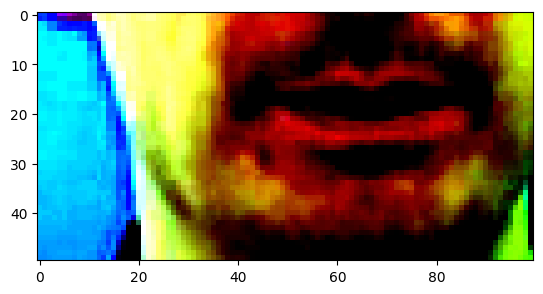

In [18]:
plt.imshow(frames.numpy()[20])

In [19]:
alignments

tensor([ 2,  9, 14, 27,  2, 12, 21,  5, 27,  1, 20, 27, 12, 27, 19,  9, 24, 27,
        14, 15, 23])

In [20]:
text = ''.join([num_to_char[i.item()] for i in alignments])

print(text)

bin blue at l six now


## 1.2 Creating Data Pipeline
Creating a neural network is great, but having a structured data pipeline helps in structured training and increasing the amount of training data we are using at any point for a better model.

In [21]:
from matplotlib import pyplot as plt

In [22]:
import glob
import random
from torch.utils.data import Dataset, DataLoader

'''
  PyTorch Dataset class to fetch items and other operation requirements.

'''

class LipNetDataset(Dataset):
    def __init__(self, data_dir='./data/s1/*.mpg'):
        self.file_paths = glob.glob(data_dir)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]

        frames, alignments = load_data(path)
        return frames, alignments

In [23]:
from torch.nn.utils.rnn import pad_sequence

'''
  For a complete batch of items, we need to pad the items accordingly and return processed items.

'''

def collate_fn(batch):
    frames, alignments = zip(*batch)

    frame_lengths = torch.tensor([f.shape[0] for f in frames])
    alignment_lengths = torch.tensor([len(a) for a in alignments])

    # Pad sequences
    padded_frames = pad_sequence(frames, batch_first=True, padding_value=0)
    padded_alignments = pad_sequence(alignments, batch_first=True, padding_value=0)

    # Permute to (N, C, T, H, W) for Conv3D
    padded_frames = padded_frames.permute(0, 4, 1, 2, 3)

    return padded_frames, padded_alignments, frame_lengths, alignment_lengths


In [24]:
from torch.utils.data import random_split

'''
  Creating train and test dataloader to facililate the training and testing process

'''

full_dataset = LipNetDataset()

train_size = 900
test_size = 100
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

print(f"Total samples: {len(full_dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Total samples: 1000
Training samples: 900
Testing samples: 100


In [25]:
len(test_loader)

13

In [26]:
'''
  Creating an iterator from train_loader dataloader

'''

data_iterator = iter(train_loader)

frames, alignments, _, _ = next(data_iterator)

print(f"Frames tensor shape: {frames.shape}")
print(f"Frames tensor dtype: {frames.dtype}")
print(f"Alignments tensor shape: {alignments.shape}")
print(f"Alignments tensor dtype: {alignments.dtype}")

Frames tensor shape: torch.Size([8, 3, 75, 50, 100])
Frames tensor dtype: torch.float32
Alignments tensor shape: torch.Size([8, 30])
Alignments tensor dtype: torch.int64


In [27]:
len(frames)

8

In [28]:
sample_iterator = iter(train_loader)

In [29]:
val = next(sample_iterator)

val[0]

tensor([[[[[ 0.6292,  0.9407,  1.2967,  ...,  0.2955, -0.6390, -0.9949],
           [ 0.5847,  0.9407,  1.3634,  ...,  0.2955, -0.6390, -1.0394],
           [-0.1272,  0.4957,  1.2522,  ..., -0.1272, -1.5734, -1.8404],
           ...,
           [-1.4622, -1.8181, -2.1074,  ..., -3.0863, -2.8861, -2.6191],
           [-1.4622, -1.8404, -2.1964,  ..., -3.0418, -2.8638, -2.7081],
           [-1.4622, -1.9071, -2.2409,  ..., -3.0418, -2.8638, -2.7971]],

          [[ 0.7850,  1.0074,  1.2299,  ...,  0.2955, -0.5945, -1.0617],
           [ 0.6960,  1.0074,  1.2522,  ...,  0.2732, -0.6390, -1.1729],
           [-0.2385,  0.5847,  1.3189,  ..., -0.0382, -1.2397, -1.7291],
           ...,
           [-1.6401, -1.8626, -2.1296,  ..., -2.9751, -2.9083, -2.6858],
           [-1.5734, -1.8849, -2.1964,  ..., -2.9751, -2.9306, -2.8861],
           [-1.5067, -1.9516, -2.2631,  ..., -3.0418, -2.9751, -2.9083]],

          [[ 0.8517,  1.0297,  1.2299,  ...,  0.3622, -0.5722, -1.0839],
           [ 0.

In [30]:
video_tensor = val[0][0]   # Took first video frames out from the batch

# Permute the tensor from (C, T, H, W) to (T, H, W, C) for imageio
frames_to_save = video_tensor.permute(1, 2, 3, 0)

frames_for_gif = frames_to_save.to(torch.uint8).numpy()

# Now frames_for_gif has the correct shape (75, 50, 100, 3)
imageio.mimsave('./animation.gif', frames_for_gif, fps=10)

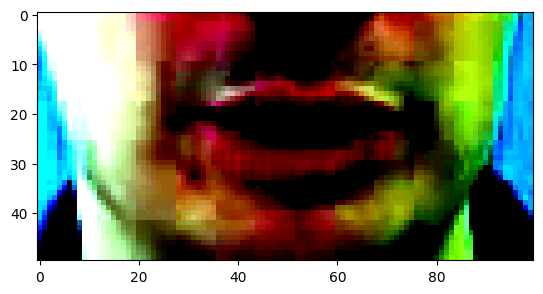

In [31]:
first_video_tensor = val[0][0]

frame_tensor = first_video_tensor[:, 36, :, :]   # 36th frame from the first video

frame_to_plot = frame_tensor.permute(1, 2, 0).numpy()

plt.imshow(frame_to_plot)

In [32]:
first_alignment_tensor = val[1][0]
text = ''.join([num_to_char[i.item()] for i in first_alignment_tensor])

print(text)

place red at x zero please


## 1.3. Neural Network Design

We are using Spatial CNN, a.k.a, 3D Convolution layers to pass the video and eventually condense it to classification problem to predict characters from our defind vocabulary.

We are using special loss function, CTC, a.k.a, Connectionist Temporal Classification loss. It is used in training neural networks for sequence problems where the timing of the input data is variable. It is particularly useful in applications like speech recognition and handwriting recognition. CTC is specially built for this type of problem and reduces the duplicates using a special token.

In [33]:
'''
  Importing required models from PyTorch for the neural network creation.

'''

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler # Base class for custom schedulers

In [34]:
'''
  Model is created as a sequential type which contains three 3D convolutional layers, followed by a time distributed
  flattening layer, two Bidirectional GRU and finally a dense layer with 28 outputs and softmax activation for classification
  problem.

'''


class LipNet(nn.Module):
    def __init__(self, vocab_size):
        super(LipNet, self).__init__()

        self.conv_block = nn.Sequential(
            # Input: (N, 3, 75, 50, 100) -> (N, C, T, H, W)
            nn.Conv3d(3, 32, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),

            nn.Conv3d(32, 64, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),

            nn.Conv3d(64, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        )

        self.gru1 = nn.GRU(
            input_size=1728, # 96 * 3 * 6
            hidden_size=256,
            bidirectional=True,
            batch_first=True
        )
        self.dropout1 = nn.Dropout(0.5)

        self.gru2 = nn.GRU(
            input_size=512,  # 256 * 2 from bidirectional GRU
            hidden_size=256,
            bidirectional=True,
            batch_first=True
        )
        self.dropout2 = nn.Dropout(0.5)

        self.fc = nn.Linear(512, vocab_size) # 256 * 2

    def forward(self, x):
        # x is (N, C, T, H, W)
        x = self.conv_block(x)

        x = x.permute(0, 2, 1, 3, 4)
        batch_size, time_steps, _, _, _ = x.size()
        x = x.reshape(batch_size, time_steps, -1)

        x, _ = self.gru1(x)
        x = self.dropout1(x)
        x, _ = self.gru2(x)
        x = self.dropout2(x)

        x = self.fc(x)

        x = x.permute(1, 0, 2)
        return F.log_softmax(x, dim=2)

## 1.4. Training the Neural Network

We need to define our loss function, optimizers, callbacks and learning rate schedular, all of which requires some type of hyperparameter which need to be tuned for a better model.


In [35]:
'''
  Weight initialization is one of the important techniques to get better convergence
  and save from felling into the trap of local minima

'''

def initialize_weights(m):
    if isinstance(m, nn.Conv3d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data)
            else:
                nn.init.normal_(param.data)

In [36]:
# The vocabulary size is 27 characters + 1 blank token for CTC
vocab_size = 28

model = LipNet(vocab_size=vocab_size).to(device)

model.apply(initialize_weights)

LipNet(
  (conv_block): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(32, 64, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(64, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU()
    (8): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru1): GRU(1728, 256, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (gru2): GRU(512, 256, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=28, bias=True)
)

In [37]:
import math

'''
  There is a need to define a learning rate rescheduler so to reduce the chance of overshooting the point of minima.
  This function reduces the learning rate as the number of epochs increases and the model getting closer to optimum.

'''

def lr_lambda_rule(epoch):
    if epoch < 30:
        return 1.0
    else:
        return math.exp(-0.1 * (epoch - 29))

In [38]:
from torch import optim
from torch.optim import lr_scheduler
import torch.nn as nn

'''
  Initiating the Adam optimizer and learning rate scheduler and CTC Loss.

'''

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      # Halve the LR instead of dividing by 5
    patience=5,     # Wait 5 epochs instead of 10
)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

In [39]:
'''
  Fetches a single batch, runs inference, decodes the output,
  and prints the original vs. predicted text, at the end of each epoch

'''


def produce_example(model, dataloader, num_to_char, device):
    model.eval()

    padded_frames, padded_alignments, frame_lengths, alignment_lengths = next(iter(dataloader))
    padded_frames = padded_frames.to(device)

    with torch.no_grad():
        log_probs = model(padded_frames)
        predicted_indices = torch.argmax(log_probs, dim=2)


    for i in range(padded_frames.size(0)):
        original_indices = padded_alignments[i][:alignment_lengths[i]]
        original_text = ''.join([num_to_char[idx.item()] for idx in original_indices])

        pred_indices_item = predicted_indices[:, i]

        uniqued_indices = torch.unique_consecutive(pred_indices_item)
        filtered_indices = [i for i in uniqued_indices if i != 0]

        predicted_text = ''.join([num_to_char[idx.item()] for idx in filtered_indices])

        print(f"Original:    {original_text}")
        print(f"Prediction:  {predicted_text}")
        print('~'*100)


    model.train()   # Set the model back to training mode for the next epoch

In [ ]:
'''
  Complete training pipeline with callbacks, optimizer, learning rate scheduler
  and example prediction.

'''


epochs = 100
start_epoch = 0
best_loss = float('inf')
save_path = os.path.join('models', 'checkpoint.weights.pt')
os.makedirs('models', exist_ok=True)

# Check if a checkpoint file exists to resume from
if os.path.exists(save_path):
    print("Loading checkpoint...")
    model.load_state_dict(torch.load(save_path))
    start_epoch = 51
    print(f"Resuming training from epoch {start_epoch + 1}")


# Main Training Loop
for epoch in range(start_epoch, epochs):
    print(f"\n--- Epoch {epoch+1}/{epochs} ---")

    model.train()
    running_loss = 0.0
    for batch_idx, (frames, alignments, frame_lengths, alignment_lengths) in enumerate(train_loader):
        frames = frames.to(device)
        alignments = alignments.to(device)

        optimizer.zero_grad()

        log_probs = model(frames)

        loss = criterion(log_probs, alignments, frame_lengths, alignment_lengths)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 10 == 0: # Print progress every 10 batches
            print(f"  [Batch {batch_idx+1}/{len(train_loader)}] Training Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)
    print(f"End of Epoch {epoch+1} - Average Training Loss: {avg_train_loss:.4f}")

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for frames, alignments, frame_lengths, alignment_lengths in test_loader:
            frames = frames.to(device)
            alignments = alignments.to(device)

            log_probs = model(frames)
            val_loss = criterion(log_probs, alignments, frame_lengths, alignment_lengths)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(test_loader)
    print(f"End of Epoch {epoch+1} - Average Validation Loss: {avg_val_loss:.4f}")

    # Callbacks Logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"-> Checkpoint saved to {save_path}")

    scheduler.step(avg_val_loss)

    print("\n--- Generating example prediction ---")
    produce_example(model, test_loader, num_to_char, device)

Loading checkpoint...
Resuming training from epoch 52

--- Epoch 52/100 ---
  [Batch 10/113] Training Loss: 0.4842
  [Batch 20/113] Training Loss: 0.5791
  [Batch 30/113] Training Loss: 0.4378
  [Batch 40/113] Training Loss: 0.6213
  [Batch 50/113] Training Loss: 0.5397
  [Batch 60/113] Training Loss: 0.4783
  [Batch 70/113] Training Loss: 0.4425
  [Batch 80/113] Training Loss: 0.4272
  [Batch 90/113] Training Loss: 0.5693
  [Batch 100/113] Training Loss: 0.5362
  [Batch 110/113] Training Loss: 0.4186
End of Epoch 52 - Average Training Loss: 0.4985
End of Epoch 52 - Average Validation Loss: 0.7506
-> Checkpoint saved to models/checkpoint.weights.pt

--- Generating example prediction ---
Original:    lay blue with l one again
Prediction:  lay blue wit r e again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original:    bin red with g six now
Prediction:  bin red with i i now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

KeyboardInterrupt: 

In [ ]:
# --- Complete Single-Batch Overfitting Test ---
print("Fetching a single batch to overfit...")
frames, alignments, frame_lengths, alignment_lengths = next(iter(train_loader))
frames, alignments = frames.to(device), alignments.to(device)

print("Starting single-batch overfitting test...")
model.train()
for i in range(400):
    optimizer.zero_grad()
    log_probs = model(frames)
    loss = criterion(log_probs, alignments, frame_lengths, alignment_lengths)
    loss.backward()
    optimizer.step()

    if (i + 1) % 20 == 0:
        print(f"  Iteration {i+1}, Loss: {loss.item():.4f}")

        # --- Decode and Print Prediction ---
        predicted_indices = torch.argmax(log_probs.detach(), dim=2)

        # Get the first item from the batch to display
        pred_indices_item = predicted_indices[:, 0]
        uniqued_indices = torch.unique_consecutive(pred_indices_item)
        filtered_indices = [idx.item() for idx in uniqued_indices if idx.item() != 0]
        predicted_text = ''.join([num_to_char[idx] for idx in filtered_indices])

        # Get the original text for comparison
        original_indices = alignments[0][:alignment_lengths[0]]
        original_text = ''.join([num_to_char[idx.item()] for idx in original_indices])

        print(f"    Original:   '{original_text}'")
        print(f"    Prediction: '{predicted_text}'")

  Iteration 20, Loss: 2.0607
    Original:   'lay green at z six now'
    Prediction: 'la e onw'
  Iteration 40, Loss: 1.9584
    Original:   'lay green at z six now'
    Prediction: 'lage  onw'
  Iteration 60, Loss: 1.8932
    Original:   'lay green at z six now'
    Prediction: 'la e onw'
  Iteration 80, Loss: 1.8432
    Original:   'lay green at z six now'
    Prediction: 'la g en onw'
  Iteration 100, Loss: 1.6901
    Original:   'lay green at z six now'
    Prediction: 'la ee a now'
  Iteration 120, Loss: 1.6390
    Original:   'lay green at z six now'
    Prediction: 'lage onw'
  Iteration 140, Loss: 1.5642
    Original:   'lay green at z six now'
    Prediction: 'la re now'
  Iteration 160, Loss: 1.5181
    Original:   'lay green at z six now'
    Prediction: 'la ge now'
  Iteration 180, Loss: 1.4678
    Original:   'lay green at z six now'
    Prediction: 'la gre now'
  Iteration 200, Loss: 1.3831
    Original:   'lay green at z six now'
    Prediction: 'ay gren onw'
  Iteratio

## 1.5. Testing the trained Model

In [ ]:
save_path = os.path.join('models', 'checkpoint.weights.pt')
os.makedirs('models', exist_ok=True)

# Check if a checkpoint file exists to resume from
if os.path.exists(save_path):
    print("Loading checkpoint...")
    model.load_state_dict(torch.load(save_path))

In [ ]:
test_iterator = iter(test_loader)

In [ ]:
sample = next(test_iterator)

In [ ]:
model.eval()

with torch.no_grad():
    yhat = model(sample[0].to(device))

In [ ]:
print('~'*100, 'REAL TEXT')

alignments_batch = sample[1]

real_texts = [''.join([num_to_char[i.item()] for i in sentence]) for sentence in alignments_batch]
print(real_texts)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
['lay blue with l one again', 'bin red with g six now', 'place red with d seven again', 'set green in o six now', 'place green at q nine again', 'bin green by b three again', 'place white by y one again', 'bin green at u one again']


In [ ]:

first_prediction = yhat[:, 0, :]

# greedy approach
predicted_indices = torch.argmax(first_prediction, dim=1)
uniqued_indices = torch.unique_consecutive(predicted_indices)
decoded = torch.tensor([i for i in uniqued_indices if i != 0]).numpy()

print(decoded)

[12  1 25 27  2 12 21  5 27  9  8 27  8 27 15  5 27  1  7  1  9 14]


In [ ]:
'''
  Perform Greedy CTC Decode for the whole batch

'''

predicted_indices = torch.argmax(yhat, dim=2)

decoded_sequences = []

for i in range(predicted_indices.size(1)):
    item_indices = predicted_indices[:, i]
    uniqued_indices = torch.unique_consecutive(item_indices)
    filtered_indices = [idx.item() for idx in uniqued_indices if idx.item() != 0]
    decoded_sequences.append(filtered_indices)

print('~'*100, 'PREDICTIONS')

predicted_texts = [''.join([num_to_char[idx] for idx in sentence]) for sentence in decoded_sequences]
print(predicted_texts)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
['lay blue ih h oe again', 'bin red with i i now', 'plac green with h e again', 'set green at a sie non', 'set green it h i now', 'bin green wih x fe soon', 'place rited by r e again', 'bin green wit t e again']


In [46]:
'''
  Loads a trained model, runs inference on a single video,
  and returns both the real (ground truth) and predicted text.

'''

def predict_video(model_path, video_path, device, num_to_char):

    print("Loading model from checkpoint...")
    model = LipNet(vocab_size=len(num_to_char))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # print(f"Loading video: {video_path}")
    video_tensor = load_video(video_path)
    input_tensor = video_tensor.permute(3, 0, 1, 2).unsqueeze(0).to(device)

    frames_for_gif = video_tensor.to(torch.uint8).numpy()
    imageio.mimsave('./animation.gif', frames_for_gif, fps=10)

    # 3. Perform Inference
    print("Making prediction...")
    with torch.no_grad():
        log_probs = model(input_tensor)

    # 4. Decode the Predicted Output
    predicted_indices = torch.argmax(log_probs.detach(), dim=2)
    pred_indices_item = predicted_indices.squeeze(1)
    uniqued_indices = torch.unique_consecutive(pred_indices_item)
    filtered_indices = [idx.item() for idx in uniqued_indices if idx.item() != 0]
    predicted_text = ''.join([num_to_char.get(idx, '') for idx in filtered_indices])

    # 5. Load and Decode the Real (Ground Truth) Text
    print("Loading ground truth text...")
    base_name = os.path.basename(video_path)
    file_name, _ = os.path.splitext(base_name)
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    alignments = load_alignments(alignment_path)
    real_text = ''.join([num_to_char.get(idx.item(), '') for idx in alignments])

    return real_text, predicted_text

In [47]:
# Define the path to your best saved checkpoint
model_checkpoint_path = 'models/checkpoint.weights_75.pt'
# Define the path to a video you want to test
video_to_test = './data/s1/bbaf2n.mpg'

# Run the prediction and get both strings back
real_text, predicted_text = predict_video(model_checkpoint_path, video_to_test, device, num_to_char)

# Print the final comparison
print(f"Video File:     {video_to_test}")
print()
print('~'*50, 'REAL TEXT')
print(f"      {real_text}")
print('~'*50, 'Predicted TEXT')
print(f"      {predicted_text}")


Loading model from checkpoint...
Loading video: ./data/s1/bbaf2n.mpg
Making prediction...
Loading ground truth text...
Video File:     ./data/s1/bbaf2n.mpg

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
      bin blue at f two now

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Predicted TEXT
      bin blue by f fouro now
